### Names of Students and ID: Vincent Eichhorn, Josef Pribbernow
### Group number: J

# Clustering of image data with Mixture Models


We saw in the last project that mixture models / k-means are a powerful way to detect groups in multidimensional real data. However, mixture models can be easily generalized to other types of data.
The goal of the project is to implement a mixture model that can cluster image data using a mixture of bernoulli distributions. 
This jupyter notebook will serve as a guide for the different steps of the implementation of the model and of its estimation. In the last part we will try to apply our model to recover missing part of an image! This is also called imputation.

You will find expected outputs throughout the notebook that should match your output for the same example input, given the correct implementation of the function bodys.

`Note:` Throughout the notebook you will find docstrings describing the in and output of the different functions, these are meant as hints to guide during the implementation. Whether you meet the exact type or not is up to you and will not be graded as long as your implementation returns the expected result. If your implementation is slow it might be sufficient to use half of the dataset for good results.

### For grading, you are just expected to fill in this notebook. Feel free to add text answers within the notebook whenever appropriate.

#### Have fun!

In [1]:
# # Here are some helpful packages to solve this exercise
# # You might need to restart the notebook kernel for these to be available for import after the installation
# # The tensorflow package is only needed to load the MNIST datasets. You can avoid to installing it if you 
# # plan to download the table on your own.
# %pip install tensorflow

# %pip install matplotlib
# %pip install numpy
# %pip install scipy
# %pip install plotly

# Know your data
Have a look at the `MNIST` data set below; Get familiar with how the data is structured, this will be important for later excercises as well!

We will use prepared versions of the datasets that are already available in [Keras](https://keras.io/getting_started/). You will need to install `keras` with `Tensorflow`. Alternatively there are also tabular versions to download on Kaggle of the [digit](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv) and the [fashion](https://www.kaggle.com/datasets/zalando-research/fashionmnist) datasets. 

In [2]:
import keras
from keras.datasets import mnist
import numpy as np

(X_train, Y_train), (test_X, test_y) = mnist.load_data()
X_train = np.concatenate([X_train, test_X], axis=0)
Y_train = np.concatenate([Y_train, test_y], axis=0)
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))

example_1_X = X_train[8]
example_3_X = X_train[7]
example_7_X = X_train[40000]
example_7_y = Y_train[40000]
example_8_X = X_train[17]
print(f"This is a 7: \n{example_7_y}")
print(f"And it has shape: \n{example_7_X.shape}")
print(f"This is a 7's image data: \n{example_7_X}")

2025-11-27 15:14:45.317379: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-27 15:14:45.326861: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-27 15:14:45.691522: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-27 15:14:47.238197: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

X_train: (70000, 28, 28)
Y_train: (70000,)
This is a 7: 
7
And it has shape: 
(28, 28)
This is a 7's image data: 
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   5   4   7  

### 1) Get familiar with the dataset by plotting some of the $x_i$ in $X_{\text{train}}$.

From the last section you might have seen that the value matrices $x \in \mathbb{N}^{d\times d} $ are actually 2D numpy arrays of shape (d, d). These resemble the pixels in the image, where each value indicates the respective pixels intensity.

Have a look at how this translates into the actual image by plotting some examples below, this will come in handy later on!


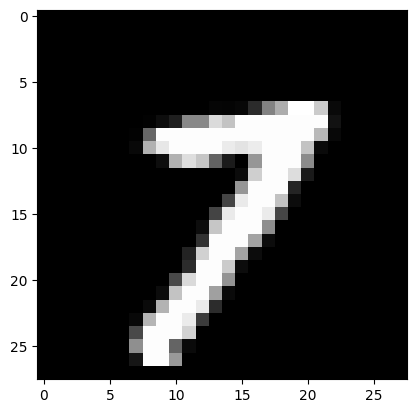

In [3]:
import matplotlib.pyplot as plt

# Plot some examples from X_train using matplotlib
plt.imshow(example_7_X, cmap = 'grey')

## 2) Preprocessing

You can see in the plot that the value matrices of the different $x$ contain values $\in \{0, 1, ..., 255\}$, representing pixel intensity on the grey scale. However, we want to reduce dimensionality for this project and transform all values to be in ${0,1}$ while keeping a meaningful representation of the original image. This will help us later when we want to think more in terms of probabilities, e.g., the probability for a pixel being on (white) given its image class. We can then model each pixel as an independant Bernoulli for our approximation. In addition, we will later work on (flattened matrices) vectors $\vec{v} \in \mathbb{N}^{d*d}$ instead of matrices $x \in \mathbb{N}^{d\times d}$.

2.a) Implement the fuction body of `binarize_image()` that flattens a given input matrix of dimension $d \times d$ and returns a binarized vector of dimension $d^2$, given a binarization `threshold`.

In [4]:
def binarize_image(xi_mat: np.ndarray, threshold: int = 127):
    """
    Convert 2D value matrix of shape (d, d) of greyscale image to 1D binary vector of shape (d * d).

    Parameters
    ----------
    xi_mat : np.ndarray
        A 2D NumPy array of shape (d, d) representing a grayscale image,
        where each element is a pixel intensity value between 0 and 255.

    threshold: int
        Decision threshold value above which all pixel values are set to 1,
        below (or equal to) which they are set to 0. Default is 127.

    Returns
    -------
    xi_bin_vec : np.array
        A 1D NumPy array of shape (d * d) representing the binary vector
        of the input image, where each element is either 0 or 1 (binary vector).
    """
    
    # Flatten the 2D image matrix to a 1D vector
    xi_flat = xi_mat.flatten()

    # Binarize the flattened vector based on the threshold
    xi_bin_vec = np.where(xi_flat > threshold, 1, 0)

    return xi_bin_vec
  

test_mat = np.array([
    [0, 127, 255],
    [255, 128, 0],
    [0, 126, 255]
])

test_mat = np.array([
       [ 80,  80,   0,   0,  80,   0,   0,  80,  80,  80],
       [ 80,   0, 255, 255,   0, 255, 255,   0,  80,  80],
       [ 80,   0, 255, 255, 255,   0, 255,   0,  80,  80],
       [ 80,  80,   0,   0,   0,   0,   0,   0,  80,  80],
       [ 80,   0,   0, 192,   0, 192, 192, 192,   0,  80],
       [  0, 192,   0, 192,   0, 192, 192, 192, 192,   0],
       [  0, 192,   0, 192,   0, 192, 192,  50, 192,   0],
       [  0, 192,   0, 192,   0, 192, 192, 192, 192,   0],
       [ 80,   0,   0, 192,   0, 192, 192, 192,   0,  80],
       [ 80,  80,   0,   0,   0,   0,   0,   0,  80,  80]
])

test_bin_vec = np.array([0, 0, 1, 1, 1, 0, 0, 0, 1])

test_bin_vec = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
                         1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
                         0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
                         1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
                         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Check if your function returns the expected result by comparing the matrices below
print(f"Expected binarized vector:\n{test_bin_vec}")
print(f"Binarized vector with your implementation:\n{binarize_image(test_mat)}")

assert np.array_equal(binarize_image(test_mat), test_bin_vec), "Binarized vector returned by your implementation is not equal to the expected vector."

Expected binarized vector:
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1
 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
Binarized vector with your implementation:
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1
 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]


Printed matrices are nice, but you can never _bee_ too sure with these things. 

#### 2.b) Implement the helper function `recover_image_matrix()` to recover a binarized matrix from the vector. Plot the binarized representation matrix and have a look at how the figure changed!

After running the code on the `test_mat`, feel free to look at some other examples in the `MNIST` dataset. What do you observe?

In [5]:
def recover_image_matrix(xi_bin_vec: np.ndarray, d: int = 28):
    """
    Convert 1D binary vector of shape (d * d) to 2D binary matrix of shape (d, d) of the image.

    Parameters
    ----------
    xi_bin_vec : np.array
        A 1D NumPy array of shape (d * d) representing the binary representation
        of the input image, where each element is either 0 or 1.

    d : int
        The dimension of the square matrix to be recovered.

    Returns
    -------
    xi_bin_mat : np.ndarray
        A 2D NumPy array of shape (d, d) representing the grayscale image,
        where each element is either 0 or 1 (binary matrix).
    """
    
    # Reshape the 1D binary vector to a 2D binary matrix of shape (d, d)
    xi_bin_mat = xi_bin_vec.reshape((d, d))
    
    return xi_bin_mat


test_bin_mat = np.array([
    [0, 0, 1],
    [1, 1, 0],
    [0, 0, 1]
])

test_bin_mat = np.array([
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 1, 0, 0],
       [0, 1, 0, 1, 0, 1, 1, 1, 1, 0],
       [0, 1, 0, 1, 0, 1, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])

print(f"Expected binarized matrix:\n{test_bin_mat}")
print(f"Binarized matrix with your implementation:\n{recover_image_matrix(test_bin_vec, 10)}")

assert np.array_equal(recover_image_matrix(test_bin_vec, 10), test_bin_mat), "Binarized matrix returned by your implementation is not equal to the expected matrix."


Expected binarized matrix:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 1 1 0 0 0]
 [0 0 1 1 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 1 1 0 0]
 [0 1 0 1 0 1 1 1 1 0]
 [0 1 0 1 0 1 1 0 1 0]
 [0 1 0 1 0 1 1 1 1 0]
 [0 0 0 1 0 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Binarized matrix with your implementation:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 1 1 0 0 0]
 [0 0 1 1 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 1 1 0 0]
 [0 1 0 1 0 1 1 1 1 0]
 [0 1 0 1 0 1 1 0 1 0]
 [0 1 0 1 0 1 1 1 1 0]
 [0 0 0 1 0 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


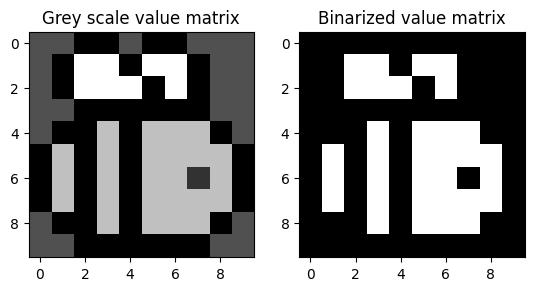

In [6]:
plt.subplot(1, 2, 1)
plt.imshow(test_mat, cmap = 'grey')
plt.title("Grey scale value matrix")
plt.subplot(1, 2, 2)
plt.imshow(test_bin_mat, cmap = 'grey')
plt.title("Binarized value matrix")
plt.show()

*What do we observe?*

> The recovered image only consists out of totally black or totally white pixels. That's caused by the binariziation mapping pixel values below the threshold to white and above the threshold to black. The use of binarization leads to a loss of information, as the grayscale values that provide more detail are discarded, also leading to a more abstract appearance of the numbers.

## 3) Class representatives

Let's get back to the `MNIST` dataset. This dataset was prepared for a supervised learning task. For each $x \in X_{\text{train}}$ we have a label $y \in Y_{\text{train}}$. We can partition $X_{\text{train}}$ into $|C|$ subsets that correspond to the images for each of the digits ($X^{(1)}$ are all the samples for digit $1$, $X^{(2)}$ for digit $2$, and so on).

$X^{(c)} = \{x \in X_{\text{train}} \mid y = c\}, \text{ with } c \in C = \{0,...9\}$

### 3.a) Compute a representative vector for a given class.
Apply the binary matrix transformations from earlier sections to the training dataset and implement the function body for `compute_class_representative()` that computes a representative value vector (flattened matrix) for a set of input matrices. Then use this function to compute representatives for $c = \{1,3,8\}$.
In this case you can think of the representative value matrix (or vector) as a matrix (or vector) in which each value resembles the probability of the corresponding pixel being white (= a value of 1). This probability is computed given all matrices (or vectors) of that class. You will compute a maximum a posteriori estimate. You may use pseudo-counts if neccessary.


`Note:` For simplicity we assume that pixels in the image data are independent of each other. Can you think of a reason why we do this? 

> This assumption simplifies the computation of the likelihood. If we would consider dependencies between pixels, we would have to estimate a joint distribution over all pixels, which is computationally infeasible given the high dimensionality of image data. For instance for the MNIST dataset with 28x28 pixels, we would have to estimate a joint distribution over 784 pixels, which would result in $784^2$ parameters in a covariance matrix alone.

Expected representative matrix: 
[0.441 0.681 0.641 0.601 0.321 0.521 0.401 0.521 0.481 0.561 0.561 0.481
 0.481 0.641 0.481 0.321 0.481 0.521 0.481 0.521 0.441 0.601 0.601 0.401]
Representative matrix with your implementation: 
[0.441 0.681 0.641 0.601 0.321 0.521 0.401 0.521 0.481 0.561 0.561 0.481
 0.481 0.641 0.481 0.321 0.481 0.521 0.481 0.521 0.441 0.601 0.601 0.401]


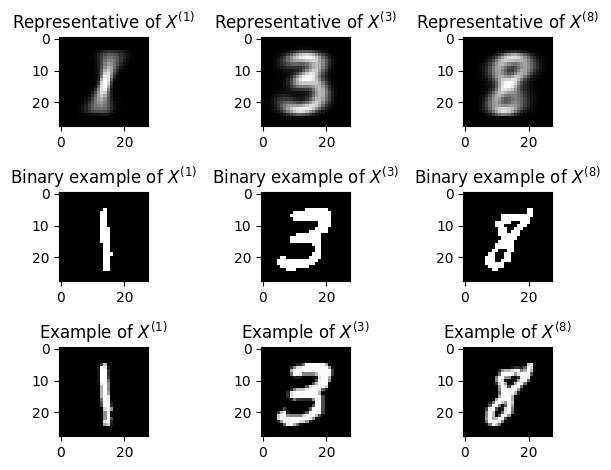

In [ ]:
def compute_class_representative(X_c: np.ndarray, pseudo_count = 1e-3):
    """
    Compute a representative value matrix for a set of input matrices.

    Parameters
    ----------
    X_c : np.ndarray
        2D array of binarized input vectors of shape (num_samples, d).
    pseudo_count: float 
        pseudo count to be added to each pixel value.
            
    Returns
    -------
    class_representative : np.array
        1D array (n_features,) representing the class representative vector.
    """

    # Calculate the mean of each column (pixel position) across all samples
    print(X_c.shape)
    mean_vector = np.mean(X_c, axis=0)

    # Add pseudo count to each element of the mean vector
    class_representative = mean_vector + pseudo_count

    return class_representative
    


test_X_c = np.random.default_rng(161).integers(0, 2, (25, 24))
test_representative = np.array([0.441, 0.681, 0.641, 0.601, 0.321, 0.521, 0.401, 0.521, 0.481, 0.561, 0.561, 0.481, 0.481, 0.641, 0.481, 0.321, 0.481, 0.521, 0.481, 0.521, 0.441, 0.601, 0.601, 0.401])

print(f"Expected representative matrix: \n{test_representative}")
print(f"Representative matrix with your implementation: \n{compute_class_representative(test_X_c)}")

assert np.array_equal(compute_class_representative(test_X_c), test_representative), "Class representative matrix returned by your implementation is not equal to the expected class representative matrix."

# Once you implemented the function body above, create subsets X_1, X_3, X_8
# from X_train and compute their representative vectors and plot them below. Use
# appropriate transformation to get back to plotable matrix data with correct
# dimensions.

# Apply binarization
X_train_bin = np.array([binarize_image(x) for x in X_train])

# Compute representatives
representative_X_1_vec = compute_class_representative(X_train_bin[Y_train == 1])
representative_X_3_vec = compute_class_representative(X_train_bin[Y_train == 3])
representative_X_8_vec = compute_class_representative(X_train_bin[Y_train == 8])

# Make plotable
representative_X_1_mat = recover_image_matrix(representative_X_1_vec, 28)
representative_X_3_mat = recover_image_matrix(representative_X_3_vec, 28)
representative_X_8_mat = recover_image_matrix(representative_X_8_vec, 28)

# Binarize examples
example_1_X_bin_vec = binarize_image(example_1_X)
example_3_X_bin_vec = binarize_image(example_3_X)
example_8_X_bin_vec = binarize_image(example_8_X)

# Make plotable
example_1_X_bin_mat = recover_image_matrix(example_1_X_bin_vec, 28)
example_3_X_bin_mat = recover_image_matrix(example_3_X_bin_vec, 28)
example_8_X_bin_mat = recover_image_matrix(example_8_X_bin_vec, 28)

plt.subplot(3, 3, 1)
plt.imshow(representative_X_1_mat, cmap = 'grey')
plt.title("Representative of $X^{(1)}$")
plt.subplot(3, 3, 2)
plt.imshow(representative_X_3_mat, cmap = 'grey')
plt.title("Representative of $X^{(3)}$")
plt.subplot(3, 3, 3)
plt.imshow(representative_X_8_mat, cmap = 'grey')
plt.title("Representative of $X^{(8)}$")

plt.subplot(3, 3, 4)
plt.imshow(example_1_X_bin_mat, cmap = 'grey')
plt.title("Binary example of $X^{(1)}$")
plt.subplot(3, 3, 5)
plt.imshow(example_3_X_bin_mat, cmap = 'grey')
plt.title("Binary example of $X^{(3)}$")
plt.subplot(3, 3, 6)
plt.imshow(example_8_X_bin_mat, cmap = 'grey')
plt.title("Binary example of $X^{(8)}$")

plt.subplot(3, 3, 7)
plt.imshow(example_1_X, cmap = 'grey')
plt.title("Example of $X^{(1)}$")
plt.subplot(3, 3, 8)
plt.imshow(example_3_X, cmap = 'grey')
plt.title("Example of $X^{(3)}$")
plt.subplot(3, 3, 9)
plt.imshow(example_8_X, cmap = 'grey')
plt.title("Example of $X^{(8)}$")
plt.tight_layout()
plt.show()

## Computing vector probabilities

#### 3.b) Write a function that computes the log probability for a set of binarized vectors

It will take as input a set of input vectors $X$ you derived from the set of `MNIST` image matrices $X_{\text{test}}$, a class representative $\vec{\mu}_c$. Be careful not to take the logarithm of zero (to avoid that we add a parameter $\varepsilon$ to the function).

Later we can use this to compute for example:

$$
\log \mathbb{P} (\vec{v} \mid y = c) = \sum_{j=1}^{784} v_j\cdot \log(\mu_{c,j}) + (1-v_j)\cdot \log (1-\mu_{c,j})
$$

In [8]:
def log_probabilities(X, class_representative, eps = 1e-7):
    """
    Compute log P(x_i | y=c) for binary X under independent Bernoulli pixels.

    Parameters
    ----------
    X : array-like, shape (n_samples, d)
        Binary inputs (0/1). If floats, values are interpreted as probabilities but should be 0/1.
    class_representative : array-like, shape (d,)
        Per-pixel probability of 1 (values in [0,1]).
    eps: float
        minimum value for the probability of a pixel to be observed (to avoid rounding errors).

    Returns
    -------
    log_probas : np.ndarray, shape (n_samples,)
        Log-likelihoods for each sample.
    """
    p = np.clip(class_representative, eps, 1.0 - eps)
    logs = X * np.log(p) + (1-X) * np.log(1-p)
    return logs.sum(axis=1)


test_log_probas = np.array([-87.87645595, -100.75135407, -74.28714557, -82.9868483, -86.35217585, -164.77564207, -79.17198904, -95.40878212])
your_log_probas = log_probabilities(X_train_bin[Y_train == 1][:8], compute_class_representative(X_train_bin[Y_train == 1][:8], pseudo_count=0))

prec = 2
assert np.array_equal(np.round(test_log_probas, prec), np.round(your_log_probas, prec)), "Samma"

print(f"Expected log probabilities:\n{test_log_probas}")
print(f"Log probabilities with your implementation:\n{your_log_probas}")

Expected log probabilities:
[ -87.87645595 -100.75135407  -74.28714557  -82.9868483   -86.35217585
 -164.77564207  -79.17198904  -95.40878212]
Log probabilities with your implementation:
[ -87.87651022 -100.75140834  -74.28719984  -82.98690257  -86.35223012
 -164.77569634  -79.17204331  -95.40883639]


## Compute the class posteriors

### 3.c) Implement `compute_class_posteriors`. 

This function takes as argument a set of representatives, and the class priors and returns a matrix of all the class posterior for each image vector in the input. You can use the function `log_probabilities()` to simplify the computation. You might also want to consider the log-sum-exp transformation to improve the numerical stability of your calculations where appropriate (there is for instance a `scipy.special.logsumexp()` function).


In [9]:
from scipy.special import logsumexp

def compute_class_posteriors(X, class_representative_lst, priors_lst):
    """
    Compute class posterior probabilities P(c_k | v_i).

    Parameters
    ----------
    X : list of np.ndarray
        List of samples (binarized vectors), shape (num_samples, d).

    class_representative_lst : list of np.ndarray
        List of class representative vectors, one per class.

    priors_lst : list or np.ndarray
        Class priors P(c_k), should sum to 1.


    Returns
    -------
    posteriors : np.ndarray
        Array of shape (num_samples, num_classes) containing the posterior P(c_k | x_i) for each class c_k and vector v_i
    """

    log_priors = np.log(np.array(priors_lst))
    log_likelihoods = np.vstack([log_probabilities(X, class_repr) for class_repr in class_representative_lst])
    denominator = logsumexp(log_likelihoods + log_priors[:, np.newaxis], axis=0)
    posteriors = np.exp(log_likelihoods + log_priors[:, np.newaxis] - denominator)
    return posteriors.T
    

representative_X_1_vec = compute_class_representative(X_train_bin[Y_train == 1], pseudo_count=0)
representative_X_3_vec = compute_class_representative(X_train_bin[Y_train == 3], pseudo_count=0)
representative_X_8_vec = compute_class_representative(X_train_bin[Y_train == 8], pseudo_count=0)

representatives_lst = [representative_X_1_vec, representative_X_3_vec, representative_X_8_vec]
X = np.array([example_1_X_bin_vec, example_3_X_bin_vec, example_8_X_bin_vec])
priors = [0.1, 0.3, 0.6]

class_posteriors = compute_class_posteriors(X, representatives_lst, priors)

expected_class_posteriors = np.array([
    [1.00000000e+00, 1.43676230e-34, 2.25592315e-33],
    [1.36608608e-89, 9.99947360e-01, 5.26398117e-05],
    [8.79971746e-23, 1.49211952e-27, 1.00000000e+00],
])

prec = 9
assert np.array_equal(np.round(class_posteriors, prec), np.round(expected_class_posteriors, prec)), "Samma"

print(f"Expected class posteriors:\n{expected_class_posteriors}")
print(f"Class posteriors with your implementation:\n{class_posteriors}")

Expected class posteriors:
[[1.00000000e+00 1.43676230e-34 2.25592315e-33]
 [1.36608608e-89 9.99947360e-01 5.26398117e-05]
 [8.79971746e-23 1.49211952e-27 1.00000000e+00]]
Class posteriors with your implementation:
[[1.00000000e+00 1.43677110e-34 2.25593411e-33]
 [1.36607772e-89 9.99947360e-01 5.26397454e-05]
 [8.79967469e-23 1.49212140e-27 1.00000000e+00]]


## 3.d) Compute the conditional log-likelihood of the vectors

Compute the conditional log-likelihood of the vectors by integrating over all possible class membership (note that you will have to compute an exponential of the log-probabilities computed with the previous function, again the log-sum-exp transformation might come in handy here).
$$
\log P(x_1,\ldots, x_n \mid (c_1, \ldots, c_K), (\mu_1, \ldots, \mu_K), (\pi_1,\ldots, \pi_K)) =
\sum_{i=1}^n \log \Big(\sum_{k=1}^K \pi_k P(x_i \mid z_i = k)\Big)
$$
`Note:` $z_i$ is the latent (non observed) variable that corresponds to the class of the vector $x_i$

In [10]:
def conditional_log_likelihood(X, class_representative_lst, priors_lst):
    """
    Compute the conditional log-likelihood of each vector x_i
    by marginalizing over all class memberships.

    Parameters
    ----------
    X : list of np.ndarray
        List of samples (binarized vectors), shape (num_samples, d).

    class_representative_lst : list of np.ndarray
        List of class representative vectors (means for each class).

    priors_lst : list or np.ndarray
        Class prior probabilities P(C_k), should sum to 1.

    Returns
    -------
    cond_log_likelihood : np.ndarray
        1D array of conditional log-likelihoods log P(x_i) for each sample.
    """
    # Your code here
    log_priors = np.log(np.array(priors_lst))
    log_likelihoods = np.vstack([log_probabilities(X, class_repr) for class_repr in class_representative_lst]) # shape (num_classes, num_samples)
    return logsumexp(log_likelihoods + log_priors[:, np.newaxis], axis=0) # shape (num_samples,)

representative_X_1_vec = compute_class_representative(X_train_bin[Y_train == 1])
representative_X_3_vec = compute_class_representative(X_train_bin[Y_train == 3])
representative_X_8_vec = compute_class_representative(X_train_bin[Y_train == 8])
representatives_lst = [representative_X_1_vec, representative_X_3_vec, representative_X_8_vec]


cond_log_likelihood = conditional_log_likelihood(X, representatives_lst, priors)

expected_cond_log_likelihood = np.array([ -87.52055809, -178.60050244, -158.62268905])

prec = 9
assert np.array_equal(np.round(class_posteriors, prec), np.round(expected_class_posteriors, prec)), "Samma"
    
print(f"Expected conditional log-likelihoods:\n{expected_cond_log_likelihood}")
print(f"Conditional log-likelihoods with your implementation:\n{cond_log_likelihood}")



Expected conditional log-likelihoods:
[ -87.52055809 -178.60050244 -158.62268905]
Conditional log-likelihoods with your implementation:
[ -87.52055809 -178.60050244 -158.62268905]


## 4) Estimating class representatives and implementing EM _light_

In the following we will implement a simplified version of EM with binary class allocations (each sequence is in the class where it has the highest posterior probability).

We will first write a function for the E-step, then a function for the M-step, and finally combine them to EM-light.


#### 4.a) Write a function for computing the E-step of the EM algorithm

From set of vectors, class representatives and priors, we compute first compute the class posteriors and then assign clusters to the input vectors. Then compute the conditional log likelihood to track convergence.



In [ ]:
def E_step(X, class_representatives_lst, priors_lst):
    """
    Performs the E-step of a simplified EM lite algorithm.

    Parameters
    ----------
    X : np.ndarray
        Data matrix of shape (n_samples, n_features), where each row is a flattened observation.
    representatives : list of np.ndarray
        Current class representative vectors (means or prototypes).
    priors : np.ndarray
        Current class prior probabilities, shape (n_classes,).

    Returns
    -------
    assignments : np.ndarray
        Hard class assignments (argmax over posterior probabilities), shape (n_samples,).
    cond_log_likelihood : np.ndarray
        Conditional log-likelihoods log P(X), shape (n_samples,).
    """
    # Your code here
    # Calculate repsonsibilities 
    responsibilities = compute_class_posteriors(X, class_representatives_lst, priors_lst) # shape (n_samples, n_classes)
 
    # Hard assign
    assignments = responsibilities.argmax(axis=1)
 
    # For tracking convergence
    cond_log_likelihood = conditional_log_likelihood(X, class_representatives_lst, priors_lst)

    return assignments, cond_log_likelihood
 

assignments_tmp, cond_log_likelihoods = E_step(X, representatives_lst, priors)

#### 4.b) Write a function for computing the M-step of the EM algorithm

From set of vectors, cluster assignments from the E-step, and a given number of clusters K, update the class representatives and priors.



In [ ]:
def M_step(X, assignments, K):
    """
    Performs the M-step of the simplified EM algorithm.

    Parameters
    ----------
    X : np.ndarray
        Data matrix of shape (n_samples, n_features), where each row is a flattened observation.
    assignments : np.ndarray
        Hard class assignments (output of E-step), shape (n_samples,).
    K : int
        Number of classes (clusters).

    Returns
    -------
    representatives : list of np.ndarray
        Updated class representatives (mean vectors for each class).
    priors : np.ndarray
        Updated class prior probabilities (frequency of each class).
    """

    n_samples = len(X)
    representatives = []
    priors = np.zeros(K)
    for k in range(K):
        X_k = X[assignments == k]
        class_repr = compute_class_representative(X_k)
        representatives.append(class_repr)
        priors[k] = X_k.shape[0] / n_samples
    return representatives, priors

class_representatives_lst, priors_tmp = M_step(X, assignments_tmp, 3)


#### 4.c) Implementing EM

We will implement the EM algorithm with fixed class allocation:

1. Fix the number of clusters $K$. In the next part, we first will try two values: $K=10$ and $K=20$. 
2. Initialize random allocation of the representative. The most common way is to sample the $K$ representative from the set of points at random, however you can also use e.g.: `kmeans++` for better initialization, which can lead to faster convergence (there are some libraries implementing `kmeans++` that you can use).
3. Until convergence
    - run E-step
    - run M-step (update representatives and priors)
    - check if convergence criteria is met (change in max nll or min ll is smaller than tolerance threshold `tol`) or maximum number of iterations it reached





In [13]:
from sklearn.cluster import kmeans_plusplus

def EM(X, K, max_iter=100, tol=1e-4, init="random", seed=42):
    """
    Simplified EM (hard assignment) algorithm.

    Parameters
    ----------
    X : np.ndarray
        Data matrix of shape (n_samples, n_features).
    K : int
        Number of classes.
    max_iter : int, optional
        Maximum number of EM iterations.
    tol : float, optional
        Convergence tolerance for change in log-likelihood.

    Returns
    -------
    class_representatives_lst : list of np.ndarray
        Estimated class representative vectors.
    priors : np.ndarray
        Estimated class priors.
    assignments : np.ndarray
        Hard assignments for each sample.
    log_likelihoods : list of float
        Log-likelihood at each iteration.
    """

    if init == "kmeans++":
        representatives_lst, assignments = kmeans_plusplus(X, n_clusters=K, random_state=seed)
    else:
        np.random.seed(seed)
        rng = np.random.default_rng()
        init_indices = rng.choice(len(X), K, replace=False)
        representatives_lst = X[init_indices]
    priors_lst = np.ones(K) / K

    likelihoods = [-float("inf")]


    while len(likelihoods) - 1 < max_iter:
        print(f"Iteration {len(likelihoods)}", end="\r")
        assignments, cond_log_likelihoods = E_step(X, representatives_lst, priors_lst)
        newll = cond_log_likelihoods.sum()
        if abs(newll - likelihoods[-1]) < tol:
            break
        likelihoods.append(newll)

        representatives_lst, priors_lst = M_step(X, assignments, K)
    
    return representatives_lst, priors_lst, assignments, likelihoods[1:]

N = 6000
"""  """
class_representatives_lst_10_kmeans, priors_lst_10_kmeans, assignments_10_kmeans, log_likelihoods_10_kmeans = EM(X_train_bin[:N], 10, init="kmeans++")
class_representatives_lst_10_random, priors_lst_10_random, assignments_10_random, log_likelihoods_10_random = EM(X_train_bin[:N], 10, init="random")
class_representatives_lst_20_kmeans, priors_lst_20_kmeans, assignments_20_kmeans, log_likelihoods_20_kmeans = EM(X_train_bin[:N], 20, init="kmeans++")
class_representatives_lst_20_random, priors_lst_20_random, assignments_20_random, log_likelihoods_20_random = EM(X_train_bin[:N], 20, init="random")


## 5) Evaluation

Evaluating the quality of a clustering is always a complex task. In the case of the digit data, we can compare it to the digit allocation in order to assess if some clusters are better defined than others. 

In this part we will perform some simple evaluation and visualization for the typical clustering we obtained in the previous part (*e.g.* with $K=10$ and $K=20$ clusters). 

One measure that can be computed in the case where class membership are available is the **purity**. The purity is a measure of how much of a cluster describes a single class. It is defined for each cluster $C_k$ as the proportion accounted by the majority class. 
$$
\text{purity}(C_k) = \frac{1}{|C_k|}\; \max_{c=0,\ldots, 9} \quad \sum_{i=1}^{n} \mathbb{I}\{x_i \in C_k; y_i = c\}
$$


### 5.a) Plot the representative for each cluster
- How does the representatives looks like for $K=10$ clusters? Is it a sufficient number of clusters? How can you explain that?
- In the case of $K=20$, do you see any digits that seem to be spread across multiple cluster? How do you explain that? 



> For $K=10$, the representatives do not represent all 9 digits well. Some representatives are blurry and do not clearly resemble a specific digit. This is likely because 10 clusters are not enough to capture the variability in the dataset, as some digits may have multiple styles or variations that cannot be adequately represented by a single cluster. Additionally, we observe that some clusters may represent the same digit. This could be due the initialization of the representatives, as well as the data distribution itself, where certain digits may have more variations than others. This explains also why even more digits at $K=20$ are spread across multiple clusters, as the increased number of clusters allows for a finer granularity in capturing the variations within each digit class.

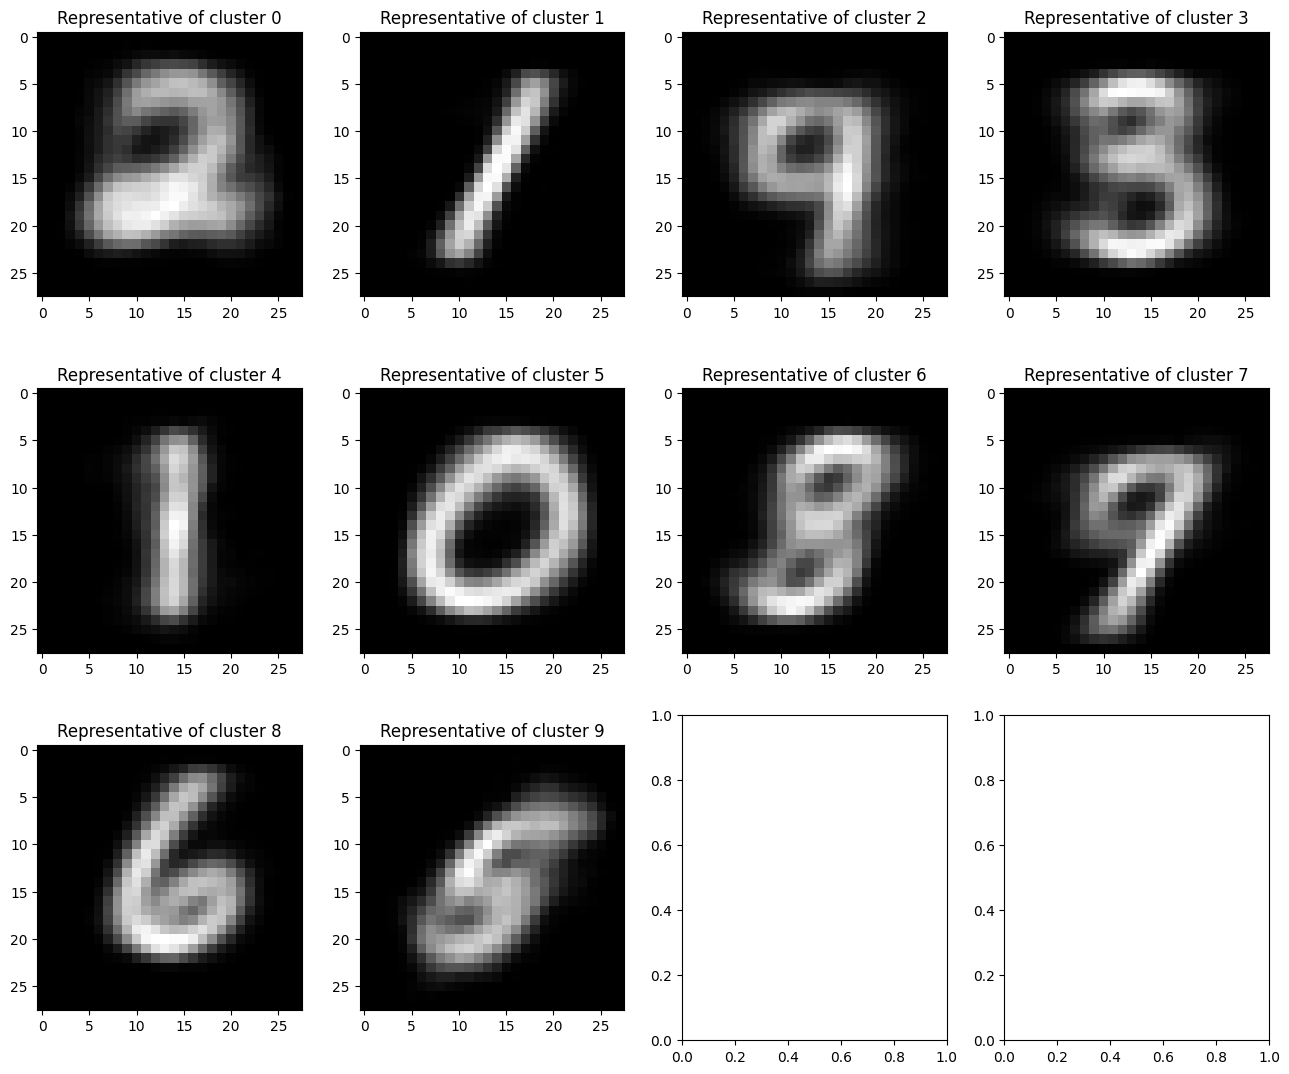

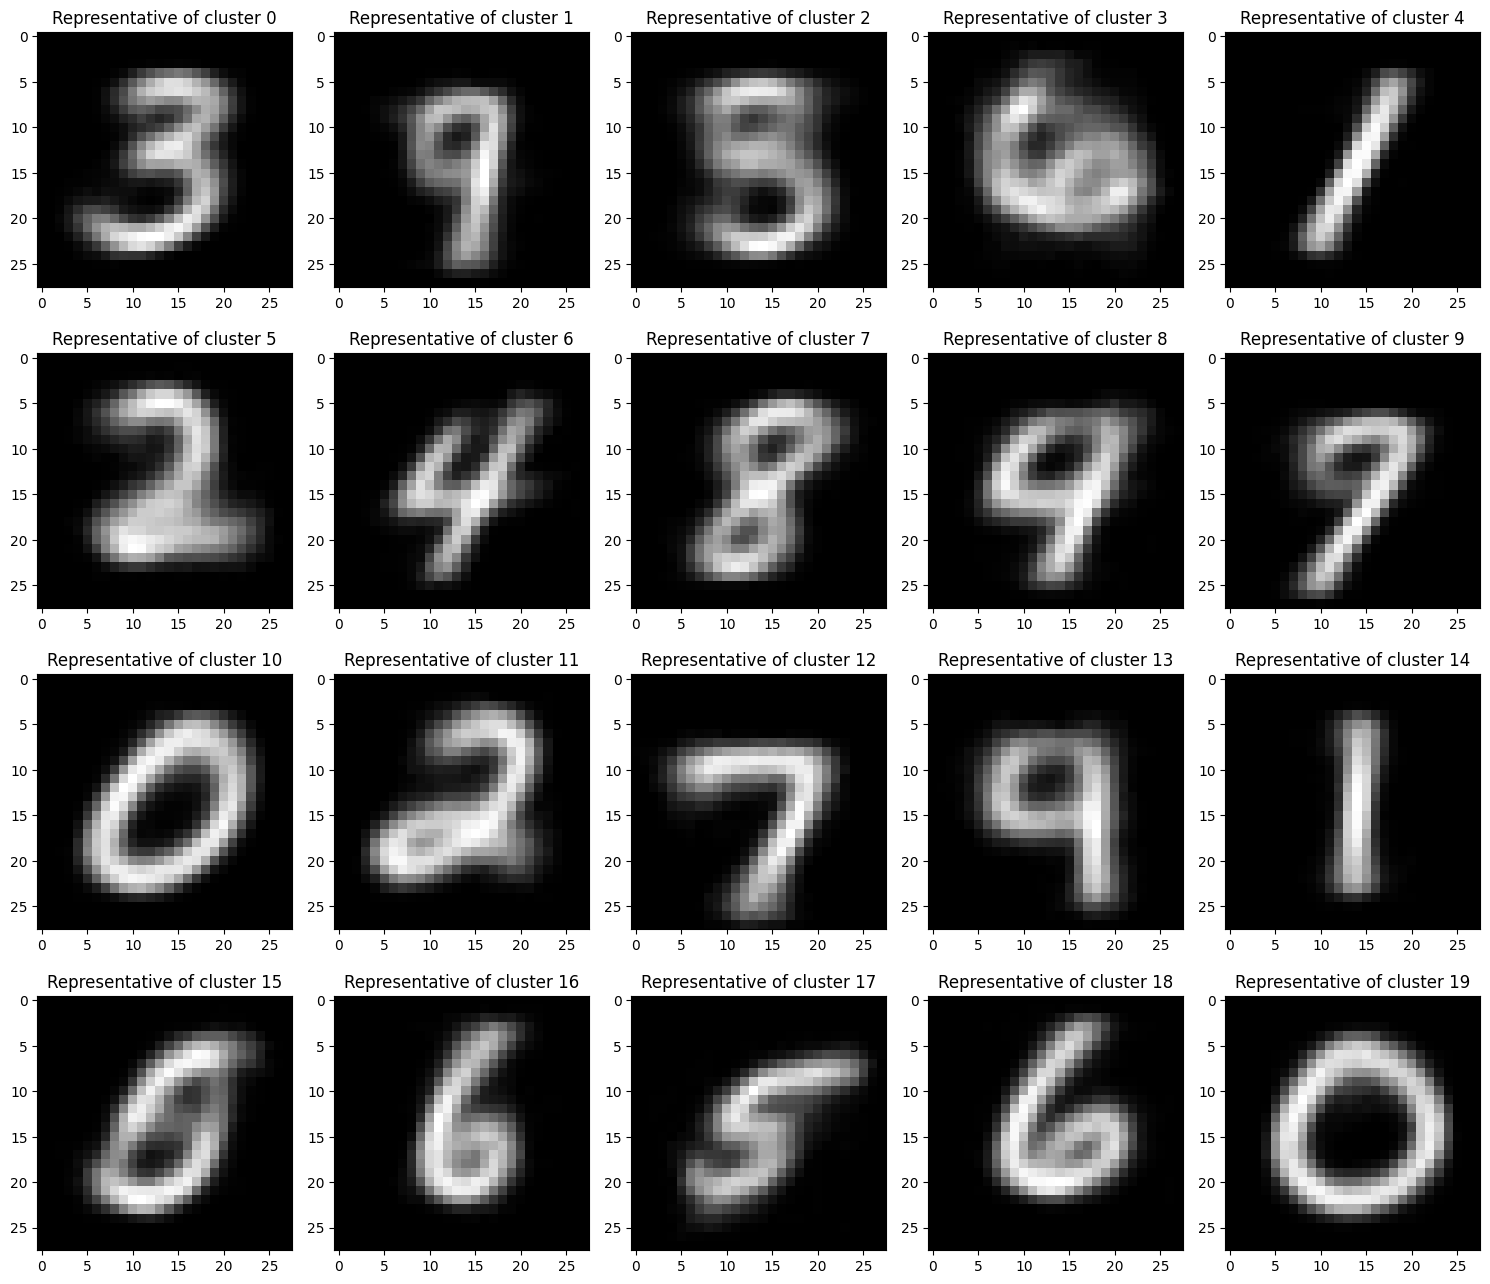

In [14]:
from math import sqrt
import random

def plot_class_representatives(class_representatives_lst):
  """
  Plot the class representatives in a grid.

  Parameters
  ----------
  class_representatives_lst : list of np.ndarray
      List of class representative vectors.
  """
  
  K = len(class_representatives_lst)
  num_rows = int(sqrt(K))
  num_cols = int(np.ceil(K / num_rows))
  fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2 + 5, num_rows * 2 + 5))
  for k in range(K):
    ## Plot the representative for each cluster

    ax.flat[k].imshow(recover_image_matrix(class_representatives_lst[k]), cmap = 'grey')
    ax.flat[k].set_title("Representative of cluster {}".format(k))
  plt.tight_layout()
  plt.show()

# plot_class_representatives(class_representatives_lst_10_kmeans)
plot_class_representatives(class_representatives_lst_10_random)

# plot_class_representatives(class_representatives_lst_20_kmeans)
plot_class_representatives(class_representatives_lst_20_random)




### 5.b) Compute the purity for each cluster 

For both $K=10$ and $K=20$, look at the clusters that get the best or the worst purity. 
- Are they associated with particular digits? 
- How could you explain that? 

> For $K=10$ the best purities are observed for a clusters which (supposably) represents the digits 0 and 1, which can make sense these digits have very consistent style. On the other hand, the worst purity is observed for a cluster which (supposably) represents a 9. The digit 9 has a similar shapes to other digitgs.

> For $K=20$, the best purity is observed for a cluster, which (supposably) represents the digit 7, which is similarly consistent in style. The worst purity is observed for a cluster which (supposably) represents a 9 as well. This observation can be explained by the fact that certain digits, like 0, 1, and 7, have more consistent and distinct shapes across different handwriting styles, leading to higher purity in their respective clusters. In contrast, digits like 9 can have more variations and similarities with other digits (like 3 or 4), resulting in lower purity as they are more likely to be confused with other classes during clustering.

In [15]:
from sklearn.metrics import adjusted_rand_score, confusion_matrix

def per_cluster_purity(y_true, y_pred):
  """
  Compute the purity for each cluster.

  Parameters
  ----------
  y_true : np.ndarray
      True class labels, shape (n_samples,).
  y_pred : np.ndarray
      Predicted cluster assignments, shape (n_samples,).

  Returns
  -------
  purity : list of float
      Purity for each cluster.
  cluster_sizes : list of int
      Size of each cluster.
  """
  K = np.unique(y_pred).shape[0]
  purities = []
  cluster_sizes = []
  for k in range(K):
      cluster_indices = np.where(y_pred == k)[0]
      cluster_size = len(cluster_indices)
      cluster_sizes.append(cluster_size)
      if cluster_size == 0:
          purities.append(0.0)
          continue
      true_labels_in_cluster = y_true[cluster_indices]
      most_common_label_count = np.bincount(true_labels_in_cluster).max()
      purities.append(most_common_label_count / cluster_size)

  return purities, cluster_sizes

def print_evaluation_results(y_true, y_pred):
    """
    Print evaluation results including confusion matrix and per-cluster purity.

    Parameters
    ----------
    y_true : np.ndarray
        True class labels, shape (n_samples,).
    y_pred : np.ndarray
        Predicted cluster assignments, shape (n_samples,).
    """

    purities, sizes = per_cluster_purity(y_true, y_pred)
    best_purity = max(purities)
    best_cluster = purities.index(best_purity)
    worst_purity = min(purities)
    worst_cluster = purities.index(worst_purity)
    print(f"Best cluster: {best_cluster} with purity {best_purity:.3f}")
    print(f"Worst cluster: {worst_cluster} with purity {worst_purity:.3f}")
    for j, (p, n) in enumerate(zip(purities, sizes)):
        print(f"- Cluster {j}: purity={p:.3f}, size={n}")
    ari = adjusted_rand_score(y_true, y_pred)
    print(f"ARI: {ari}")
    print()

    
print_evaluation_results(Y_train[:N], assignments_10_random)
print_evaluation_results(Y_train[:N], assignments_20_random)

Best cluster: 1 with purity 0.955
Worst cluster: 2 with purity 0.361
- Cluster 0: purity=0.750, size=564
- Cluster 1: purity=0.955, size=357
- Cluster 2: purity=0.361, size=881
- Cluster 3: purity=0.463, size=689
- Cluster 4: purity=0.522, size=601
- Cluster 5: purity=0.954, size=483
- Cluster 6: purity=0.456, size=691
- Cluster 7: purity=0.449, size=795
- Cluster 8: purity=0.921, size=478
- Cluster 9: purity=0.432, size=461
ARI: 0.3617977445852727

Best cluster: 12 with purity 0.972
Worst cluster: 1 with purity 0.353
- Cluster 0: purity=0.845, size=355
- Cluster 1: purity=0.353, size=496
- Cluster 2: purity=0.368, size=467
- Cluster 3: purity=0.426, size=242
- Cluster 4: purity=0.957, size=349
- Cluster 5: purity=0.901, size=273
- Cluster 6: purity=0.901, size=181
- Cluster 7: purity=0.809, size=393
- Cluster 8: purity=0.553, size=266
- Cluster 9: purity=0.597, size=419
- Cluster 10: purity=0.966, size=264
- Cluster 11: purity=0.920, size=226
- Cluster 12: purity=0.972, size=176
- Clu

## 5.c) Using Sankey Plot

[Sankey plots](https://en.wikipedia.org/wiki/Sankey_diagram) can summarize visually how globally digit identity are spread around clusters. Create a Sankey plot that matches the digits labels to the cluster allocation. In other words we will show how the digits (labelled from the _ground truth_ `Y_train`) flow into the different clusters. You can limit yourself to the case of $K=20$ for this representation. 
 
 - Consider one of the clusters with the highest purity, can you see it in the Sankey plot? 
 - Is there a digit that is reliably represented by only one cluster? 
 - If not, how many clusters are needed at minimum to represent all instances of a digit? Which digits are concerned in that case? 

> Considering cluster #5 which has the highest purity, we can see in the Sankey plot that most of the flow into this cluster comes from digit 1. This indicates that cluster #5 is primarily associated with digit 1, which aligns with our earlier observation. Only a small portion of the flow comes from other digits, suggesting that cluster #5 is a reliable representation of digit 1.
> 
> There is no digit that is reliably represented by only one cluster. Label 0, 1, 6 are represented by 2 clusters each. The remaining labels are represented by at least 3 clusters.
> 
> No digit is represented by only one cluster. At minimum 2 clusters are needed to represent nearly all instances of digits 0, 1, and 6 (excluding outliers).

In [16]:
## Plotly provides the easiest method for obtaining sankey plot with interactive visualization
import plotly.graph_objects as go 
import plotly.io as pio

# pio.renderers.default = 'browser'
pio.renderers.default = "vscode"

y_true = np.array(Y_train[:6000])
cluster_assignments = np.array(assignments_20_random)

true_labels = np.unique(y_true)
cluster_labels = np.unique(cluster_assignments)

source_labels = [f"Label {t}" for t in true_labels]
target_labels = [f"Cluster {c}" for c in cluster_labels]
all_labels = source_labels + target_labels

# Match labels and create Sankey plot
source_indices = []
target_indices = []
values = []
for t in true_labels:
    for c in cluster_labels:
        count = np.sum((y_true == t) & (cluster_assignments == c))
        if count > 0:
            source_indices.append(t)
            target_indices.append(c + len(true_labels))  # Offset for target labels
            values.append(count)
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_labels,
        color="blue"
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values
    ))])
fig.update_layout(title_text="Sankey Diagram of True Labels vs Cluster Assignments", font_size=10, height=1000)

fig.show()

## 6. The agony of choice (for a good $K$)

In this part we will see how we can use measures such as dispersion of likelihood to decide a good number of clusters $K$.

#### 6.a) Find a good number of clusters computationally. 

The negative log likelihood (`nll`) and / or the within-cluster variance can be good indicators to select the number of cluster. We will consider different values of $k$ (from 2 to 20) and monitor how the `nll` or the variance changes. We will also see how the number of cluster affect the runtime of the EM-light algorithm.  Plot and describe your findings.

- Run the mixture model for different values of $k$ from $2$ to $20$ or more and plot the `nll` as a function of $k$. Plot as well the running time of EM as a function of $k$. 
- Propose the best value for $k$, justify your choice. What about the resulting groups, are they very diverse?

> We expected to see that at some point, increasing the number of clusters K does not improve the clustering performance anymore. However, we could not observe this behavior clearly in our experiments. Maybe this could be due to the random initialiation, or that we overfit if the number of K increases too much. You can try to investigate this further by running the experiments multiple times with different random seeds and averaging the results, or by implementing a more sophisticated initialization method for the cluster representatives. We choose K=11 as the best value for K, as it provides a good balance between model complexity and performance.

In [ ]:
import time
times = []
nnls = []
results = []
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
for k in ks:
    print(f"Running EM for K={k}")
    start = time.time()
    class_reps_tmp, priors_tmp, assignments_tmp, log_likelihoods_tmp = EM(X_train_bin[:N], k, init="random")
    end = time.time()
    times.append(end - start)
    nnls.append(-log_likelihoods_tmp[-1])
    results.append((class_reps_tmp, priors_tmp, assignments_tmp, log_likelihoods_tmp))
    print(f"K={k}, time={end - start:.2f}s, NNL={-log_likelihoods_tmp[-1]:.2f}")

Running EM for K=2
K=2, time=3.10s, NNL=1171665.26
Running EM for K=3
K=3, time=4.06s, NNL=1126664.86
Running EM for K=4
K=4, time=13.99s, NNL=1096631.54
Running EM for K=5
K=5, time=12.10s, NNL=1069180.78
Running EM for K=6
K=6, time=15.80s, NNL=1044667.44
Running EM for K=7
K=7, time=20.43s, NNL=1021481.22
Running EM for K=8
K=8, time=28.67s, NNL=1005220.40
Running EM for K=9
K=9, time=14.75s, NNL=994882.45
Running EM for K=10
K=10, time=22.43s, NNL=979370.39
Running EM for K=11
K=11, time=30.02s, NNL=972215.02
Running EM for K=12
K=12, time=42.38s, NNL=959705.62
Running EM for K=13
K=13, time=26.05s, NNL=950071.06
Running EM for K=14
K=14, time=31.41s, NNL=940376.92
Running EM for K=15
K=15, time=26.19s, NNL=943977.00
Running EM for K=16
K=16, time=53.54s, NNL=928996.69
Running EM for K=17
K=17, time=31.78s, NNL=917536.68
Running EM for K=18
K=18, time=50.24s, NNL=909968.04
Running EM for K=19
K=19, time=87.92s, NNL=909331.47
Running EM for K=20
K=20, time=61.97s, NNL=901231.97


In [18]:
import plotly.express as px

fig = px.line(x=ks, y=nnls)
fig.update_layout(title="Negative Log-Likelihood vs Number of Clusters",
                  xaxis_title="Number of clusters (K)",
                  yaxis_title="Negative Log-Likelihood", 
                  width=800, height=500)
fig.show()

fig = px.line(x=ks, y=times)
fig.update_layout(title="Computation Time vs Number of Clusters",
                  xaxis_title="Number of clusters (K)",
                  yaxis_title="Computation Time (s)",
                  width=800, height=500)
fig.show()



#### 6.b) Comparing the best results

Using a Sankey plot with 3 components, represent the class allocation together with the clustering of the best value of $K$ and a value of $K=20$.

In [19]:
import time
max_nll_lst, time_lst = [], []

Kbest = 11
Kmax = 20

# three components: true allocations, k=Kbest allocations, k=Kmax allocations
y_true = np.array(Y_train[:N])
y_kbest = np.array(results[Kbest - 2][2])
y_kmax = np.array(results[Kmax - 2][2])

true_labels = np.unique(y_true)
kbest_labels = np.unique(y_kbest)
kmax_labels = np.unique(y_kmax)

# Node labels: true labels, then kbest clusters, then kmax clusters
node_labels = [f"Label {t}" for t in true_labels] + \
              [f"K{Kbest} C{c}" for c in range(Kbest)] + \
              [f"K{Kmax} C{c}" for c in range(Kmax)]

source = []
target = []
value = []

# links: true -> kbest
for t in true_labels:
    for c in range(Kbest):
        cnt = int(np.sum((y_true == t) & (y_kbest == c)))
        if cnt > 0:
            source.append(int(t))                     # true nodes at start (0..9)
            target.append(len(true_labels) + c)       # offset to kbest block
            value.append(cnt)

# links: kbest -> kmax
offset_kbest = len(true_labels)
offset_kmax = len(true_labels) + Kbest
for kb in range(Kbest):
    for km in range(Kmax):
        cnt = int(np.sum((y_kbest == kb) & (y_kmax == km)))
        if cnt > 0:
            source.append(offset_kbest + kb)
            target.append(offset_kmax + km)
            value.append(cnt)

import plotly.graph_objects as go
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      label = node_labels,
      color = "blue"
    ),
    link = dict(
      source = source,
      target = target,
      value = value
  ))])

fig.update_layout(title_text=f"Sankey: True labels -> K={Kbest} -> K={Kmax}", font_size=10, height=900)
fig.show()



## 7) Data Imputation
### Oh no! Part of the image got overwritten with `512` values! Can we recover the digit pictured on the image with our trained mixture model?

As we saw during the lecture, clustering is also a way of producing simplified representations of the data points (albeit somehow crude). We will see in the following if we can use the information in the representative to reconstruct part of the image that would have been masked. 

Below you will find our example image vectors, each masked with `512`s for some predetermined positions between pixels 100 and 400. This leaves us with some visible pixels $x_{vis}$ and some 'missing' (masked) pixels $x_{miss}$. 

We want to compute a probability for the image to below of each of the class, given the visible pixels $x_{vis}$. Then, we can reconstruct each pixel as a posterior value over all possible class allocations. 

1. Implement the function `em_impute`, that computes the posterior probabilities to belong to each class $c$ given the visible pixels of the image, given the results of the EM-lite run:

$$
p(z = c \mid x_{vis})
$$

2. Then for each missing pixel $x_j$ impute its expected value given the model parameters we trained:
$$
\mathbb{E}[x_j \mid x_{vis}] = \sum_{k=1}^{K}p(z = c_k \mid x_{vis})\cdot \mu_{k,j}
$$

3. (optional) Imagine we want to consider those 3 images with missing pixel for the estimation of the parameters. Is it possible to write a version of the EM algorithm that would take into account those images with missing values? What are the changes for the E-step and the M-step in that case? 

*3. (optional)*
> Yes, it is possible to modify the EM algorithm to handle missing values. In the E-step, we would compute the responsibilities per sample and class only with the the observed pixels and therefore the assignments. This would involve calculating the posterior probabilities for each class based only on the visible pixels. In the M-step, we would update the class representatives and priors using the posterior of the observed pixels. However if all samples of an assigned class have missing values for a particular pixel, we wouldn't be able to compute the representatives for that particular pixel. This leads to the necessity of having a big and diverse dataset.

#### 7.a) Implement `em_impute()` that takes a masked image vector, the respective mask, a set of representatives and a set of priors as input and outputs a recovered image vector with imputed values at the positions of the mask.

#### 7.b) Plot the imputed images for example 1,3, and 8 with `mask1` and `mask2` respectively. Comment on the quality of the reconstruction depending on the digit and the mask used. How would you assess the quality of the reconstruction in a more systematic way? 


`Note:` You might want to make use of `log_probabilities()`, `compute_class_posteriors()`, and `binarize_image()` functions again. 
Can you get away without calling `binarize_image()`? What do you observe?

> OMG we can impute missing values using the trained mixture model! Without binarization, the imputed images retain grayscale values, resulting in a more nuanced reconstruction. This enables us the see where the model is uncertain about pixel values, as these areas appear in shades of gray rather than stark black or white.

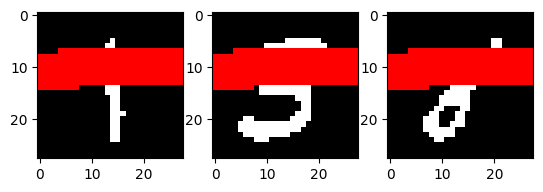

In [20]:

from matplotlib.colors import ListedColormap, BoundaryNorm

example_1_masked = example_1_X_bin_vec.copy().astype('uint16')
example_3_masked = example_3_X_bin_vec.copy().astype('uint16')
example_8_masked = example_8_X_bin_vec.copy().astype('uint16')
mask1 = np.ones(len(example_1_X_bin_vec), dtype = bool)
mask2 = np.ones(len(example_1_X_bin_vec), dtype = bool)
mask1[200:400] = False
mask2[200:600] = False
example_1_masked[~mask1] = 512
example_3_masked[~mask1] = 512
example_8_masked[~mask1] = 512

cmap = ListedColormap(['black', 'white', 'red'])
norm = BoundaryNorm([0, 0.5, 1.5, 512.5], cmap.N)

plt.subplot(1,3,1)
plt.imshow(recover_image_matrix(example_1_masked), cmap = cmap, norm=norm)
plt.subplot(1,3,2)
plt.imshow(recover_image_matrix(example_3_masked), cmap = cmap, norm=norm)
plt.subplot(1,3,3)
plt.imshow(recover_image_matrix(example_8_masked), cmap = cmap, norm=norm)
plt.show()

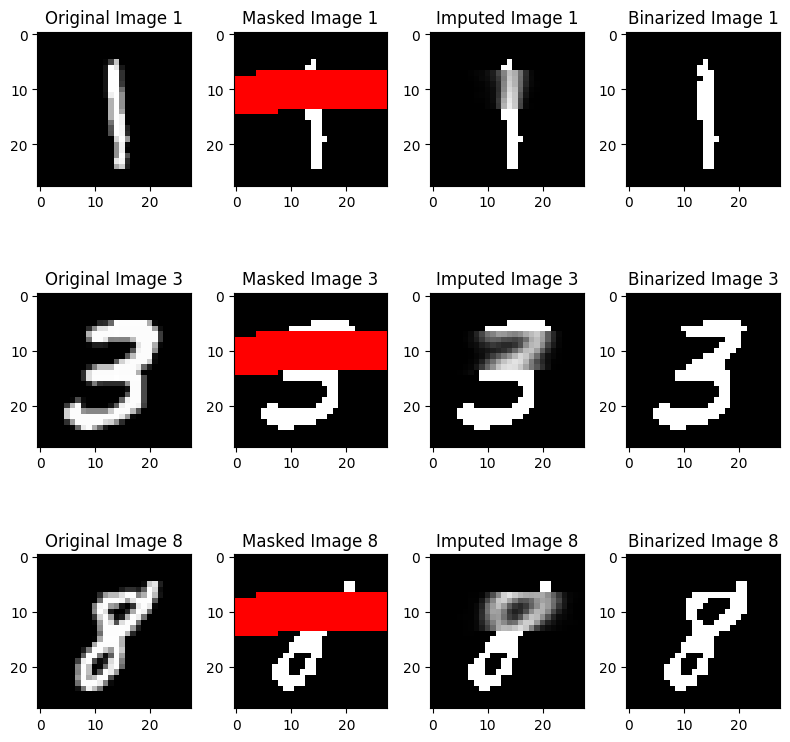

In [ ]:
def em_impute(x_masked, mask, class_representatives, class_priors, K = 10, binarize = True):
    """
    Imputes missing (masked) pixels in x_masked using parameters retrived by EM-light.
    
    Parameters
    ----------
    X_masked : np.ndarray, shape (num_samples, d)
        Each row is a flattened image (some pixels missing or zeroed)
    mask : np.ndarray, shape (d,)
        Boolean array: True for observed pixels, False for missing ones
    class_representatives : np.ndarray, shape (K, d)
        Mean vectors estimated by EM (μ_k)
    class_priors : np.ndarray, shape (K,)
        Prior probabilities for each class (π_k)
    
    Returns
    -------
    X_imputed : np.ndarray, shape (n_samples, d)
        Reconstructed images with missing pixels imputed.
    """

    class_representatives = np.array(class_representatives)
    x_masked = np.array(x_masked).astype(float)
        
    # Visible pixels
    x_vis = x_masked[mask]
    class_representatives_vis = class_representatives[:, mask]
    # Compute posterior probabilities for visible pixels
    log_priors = np.log(class_priors)
    log_likelihoods = np.vstack([log_probabilities(x_vis[np.newaxis, :], class_repr) for class_repr in class_representatives_vis])
    denominator = logsumexp(log_likelihoods + log_priors[:, np.newaxis], axis=0)
    posteriors = np.exp(log_likelihoods + log_priors[:, np.newaxis] - denominator).flatten() # shape (K,)

    # Impute missing pixels
    x_imputed = x_masked.copy()
    class_representatives_miss = class_representatives[:, ~mask]
    imputed_values = np.dot(posteriors, class_representatives_miss)
    x_imputed[~mask] = imputed_values
    if binarize:
        return binarize_image(x_imputed, threshold=0.5)
    return x_imputed
    
    #Your code here



class_representatives_lst, priors_tmp, assignments_tmp, log_likelihoods_tmp = results[18]  # K=20
example_1_imputed = em_impute(example_1_masked, mask1, class_representatives_lst, priors_tmp, K = 20)
example_3_imputed = em_impute(example_3_masked, mask1, class_representatives_lst, priors_tmp, K = 20)
example_8_imputed = em_impute(example_8_masked, mask1, class_representatives_lst, priors_tmp, K = 20)
example_1_imputed_nbin = em_impute(example_1_masked, mask1, class_representatives_lst, priors_tmp, K = 20, binarize=False)
example_3_imputed_nbin = em_impute(example_3_masked, mask1, class_representatives_lst, priors_tmp, K = 20, binarize=False)
example_8_imputed_nbin = em_impute(example_8_masked, mask1, class_representatives_lst, priors_tmp, K = 20, binarize=False)

fig, ax = plt.subplots(3, 4, figsize=(8, 8))

ax[0, 0].imshow(recover_image_matrix(example_1_X), cmap = 'gray')
ax[0, 0].set_title("Original Image 1")
ax[0, 1].imshow(recover_image_matrix(example_1_masked), cmap = cmap, norm=norm)
ax[0, 1].set_title("Masked Image 1")
ax[0, 2].imshow(recover_image_matrix(example_1_imputed_nbin), cmap = 'gray')
ax[0, 2].set_title("Imputed Image 1")
ax[0, 3].imshow(recover_image_matrix(example_1_imputed), cmap = 'gray')
ax[0, 3].set_title("Binarized Image 1")

ax[1, 0].imshow(recover_image_matrix(example_3_X), cmap = 'gray')
ax[1, 0].set_title("Original Image 3")
ax[1, 1].imshow(recover_image_matrix(example_3_masked), cmap = cmap, norm=norm)
ax[1, 1].set_title("Masked Image 3")
ax[1, 2].imshow(recover_image_matrix(example_3_imputed_nbin), cmap = 'gray')
ax[1, 2].set_title("Imputed Image 3")
ax[1, 3].imshow(recover_image_matrix(example_3_imputed), cmap = 'gray')
ax[1, 3].set_title("Binarized Image 3")

ax[2, 0].imshow(recover_image_matrix(example_8_X), cmap = 'gray')
ax[2, 0].set_title("Original Image 8")
ax[2, 1].imshow(recover_image_matrix(example_8_masked), cmap = cmap, norm=norm)
ax[2, 1].set_title("Masked Image 8")
ax[2, 2].imshow(recover_image_matrix(example_8_imputed_nbin), cmap = 'gray')
ax[2, 2].set_title("Imputed Image 8")
ax[2, 3].imshow(recover_image_matrix(example_8_imputed), cmap = 'gray')
ax[2, 3].set_title("Binarized Image 8")
plt.tight_layout()
plt.show()


## 8) One size _fits_ all? (Bonus)

Enough with all these numbers and digits! Around 2018, Zalando research proposed a new [`fashion-MNIST`](https://github.com/zalandoresearch/fashion-mnist) dataset which consider images of fashion items. This dataset contains as well 10 classes and 60,000 examples.It can be easily imported from the `keras` package. 

- Load the dataset and see how our model works on this dataset too! 
  - What is the effect of the binarization of the images in part 2? 
  - You can go over parts 4.c) to 6) on this dataset and analyze the results. 
- Does the Bernoulli mixture fits to this dataset? 
- Do you have to retrain the model parameters? What do you see?


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


(60000, 28, 28)

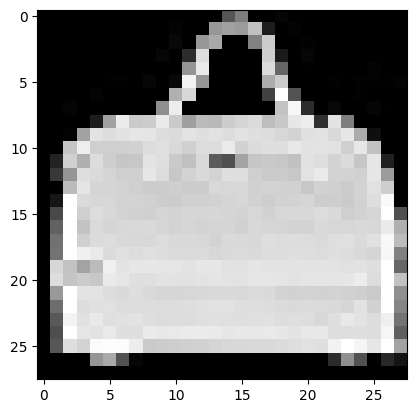

In [22]:
from keras.datasets import fashion_mnist

(F_train, E_train), (test_F, test_e) = fashion_mnist.load_data()

# You code here

example_Fashion = F_train[220]

plt.imshow(example_Fashion, cmap = 'grey')
F_train.shape

# Explanation
> If we use the learned class representatives and priors from the digit dataset directly on the fashion dataset, the imputed images do not resemble the original fashion items well. This is because the features learned from digit images are not directly transferable to fashion items.
Therefore we need to retrain the model parameters on the fashion dataset to obtain meaningful class representatives and priors that are relevant for fashion items.
As you can see in the following sankey plot we have to retrain the model for new class representatives, as the mnist digits ones do not fit

# Effect of binarization
> Binarization simplifies the image data by converting pixel values to either 0 or 1 based on a threshold. This can lead to loss of important grayscale information, which may be crucial for distinguishing between different fashion items. As a result, clustering performance degrades when using binarized images compared to using the original grayscale images.
In general the Bernoulli mixture model is less suitable for the fashion dataset compared to the digit dataset, as the fashion items have more complex features and variations that are not well captured by binary representations. Therefore, using the original grayscale images allows for better representation and clustering of the fashion items. Using the grayscale images implies the need of a different mixture model, e.g., a Gaussian mixture model, which can better capture the continuous nature of the pixel intensities in grayscale images.



In [ ]:
def sankey_plot(y_true, cluster_assignments):
    """
    Create a Sankey plot to visualize the relationship between true labels and cluster assignments.

    Parameters
    ----------
    y_true : np.ndarray
        True class labels, shape (n_samples,).
    cluster_assignments : np.ndarray
        Predicted cluster assignments, shape (n_samples,).
    """

    true_labels = np.unique(y_true)
    cluster_labels = np.unique(cluster_assignments)

    source_labels = [f"Label {t}" for t in true_labels]
    target_labels = [f"Cluster {c}" for c in cluster_labels]
    all_labels = source_labels + target_labels

    # Match labels and create Sankey plot
    source_indices = []
    target_indices = []
    values = []
    for t in true_labels:
        for c in cluster_labels:
            count = np.sum((y_true == t) & (cluster_assignments == c))
            if count > 0:
                source_indices.append(t)
                target_indices.append(c + len(true_labels))  # Offset for target labels
                values.append(count)
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=all_labels,
            color="blue"
        ),
        link=dict(
            source=source_indices,
            target=target_indices,
            value=values
        ))])
    fig.update_layout(title_text="Sankey Diagram of True Labels vs Cluster Assignments", font_size=10, height=1000)

    fig.show()


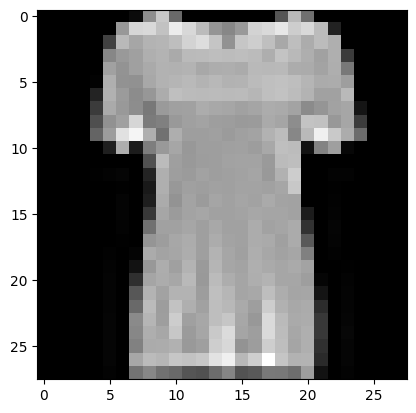

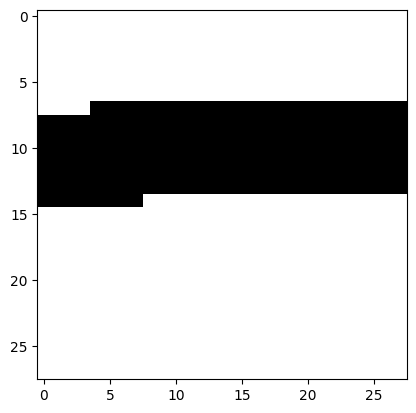

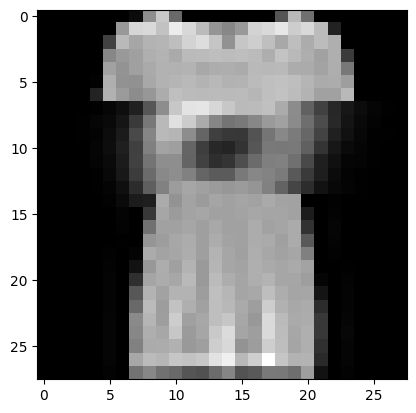

Best cluster: 18 with purity 0.157
Worst cluster: 9 with purity 0.111
- Cluster 0: purity=0.115, size=391
- Cluster 1: purity=0.126, size=293
- Cluster 2: purity=0.119, size=370
- Cluster 3: purity=0.117, size=308
- Cluster 4: purity=0.124, size=338
- Cluster 5: purity=0.135, size=348
- Cluster 6: purity=0.139, size=266
- Cluster 7: purity=0.126, size=262
- Cluster 8: purity=0.133, size=392
- Cluster 9: purity=0.111, size=296
- Cluster 10: purity=0.125, size=224
- Cluster 11: purity=0.124, size=340
- Cluster 12: purity=0.132, size=250
- Cluster 13: purity=0.126, size=294
- Cluster 14: purity=0.145, size=248
- Cluster 15: purity=0.129, size=233
- Cluster 16: purity=0.126, size=333
- Cluster 17: purity=0.125, size=296
- Cluster 18: purity=0.157, size=230
- Cluster 19: purity=0.125, size=288
ARI: -0.00021537002041800864



In [ ]:
class_representatives_lst, priors_tmp, assignments_digits, log_likelihoods_tmp = results[18]  # K=20
example_1 = F_train[10].flatten() / 255
plt.imshow(recover_image_matrix(example_1), cmap = 'gray')
plt.show()
plt.imshow(mask1.reshape((28,28)), cmap = 'gray')
plt.show()
example_1_imputed = em_impute(example_1, mask1, class_representatives_lst, priors_tmp, K = 20, binarize=False)
plt.imshow(recover_image_matrix(example_1_imputed), cmap = 'gray')
plt.show()
print_evaluation_results(E_train[:N], assignments_digits)
sankey_plot(E_train[:N], assignments_digits)


In [55]:
F_train_bin = np.array([binarize_image(x) for x in F_train])
F_train_unbin = np.array([x.flatten() / 255 for x in F_train])
N=6000
class_reps_bin, priors_bin, assignments_bin, log_likelihoods_bin = EM(F_train_bin[:N], 20, init="random")
class_reps_unbin, priors_unbin, assignments_unbin, log_likelihoods_unbin = EM(F_train_unbin[:N], 20, init="random")

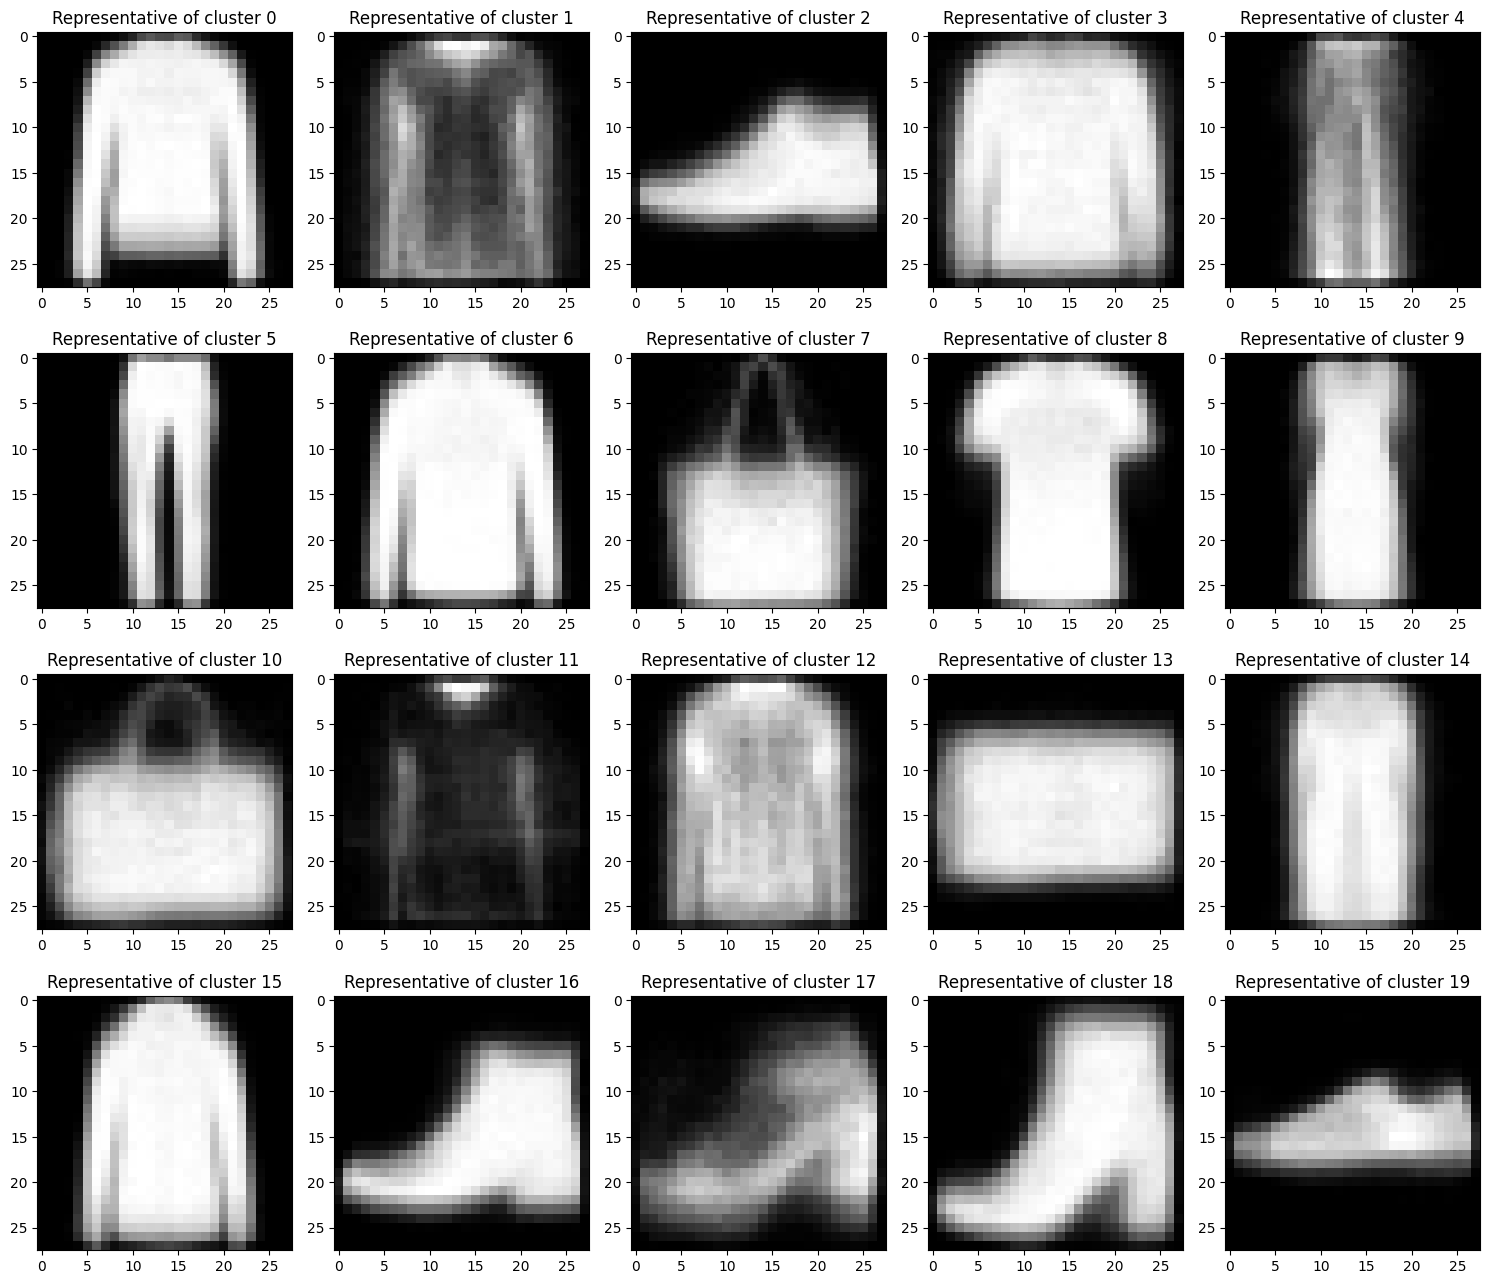

Best cluster: 5 with purity 0.994
Worst cluster: 11 with purity 0.201
- Cluster 0: purity=0.543, size=278
- Cluster 1: purity=0.286, size=287
- Cluster 2: purity=0.563, size=279
- Cluster 3: purity=0.283, size=138
- Cluster 4: purity=0.449, size=316
- Cluster 5: purity=0.994, size=476
- Cluster 6: purity=0.387, size=256
- Cluster 7: purity=0.915, size=117
- Cluster 8: purity=0.812, size=288
- Cluster 9: purity=0.912, size=307
- Cluster 10: purity=0.940, size=151
- Cluster 11: purity=0.201, size=577
- Cluster 12: purity=0.282, size=262
- Cluster 13: purity=0.969, size=193
- Cluster 14: purity=0.311, size=344
- Cluster 15: purity=0.581, size=298
- Cluster 16: purity=0.927, size=275
- Cluster 17: purity=0.646, size=347
- Cluster 18: purity=0.960, size=200
- Cluster 19: purity=0.633, size=611
ARI: 0.3133461899081683



In [56]:
plot_class_representatives(class_reps_bin)
print_evaluation_results(E_train[:N], assignments_bin)

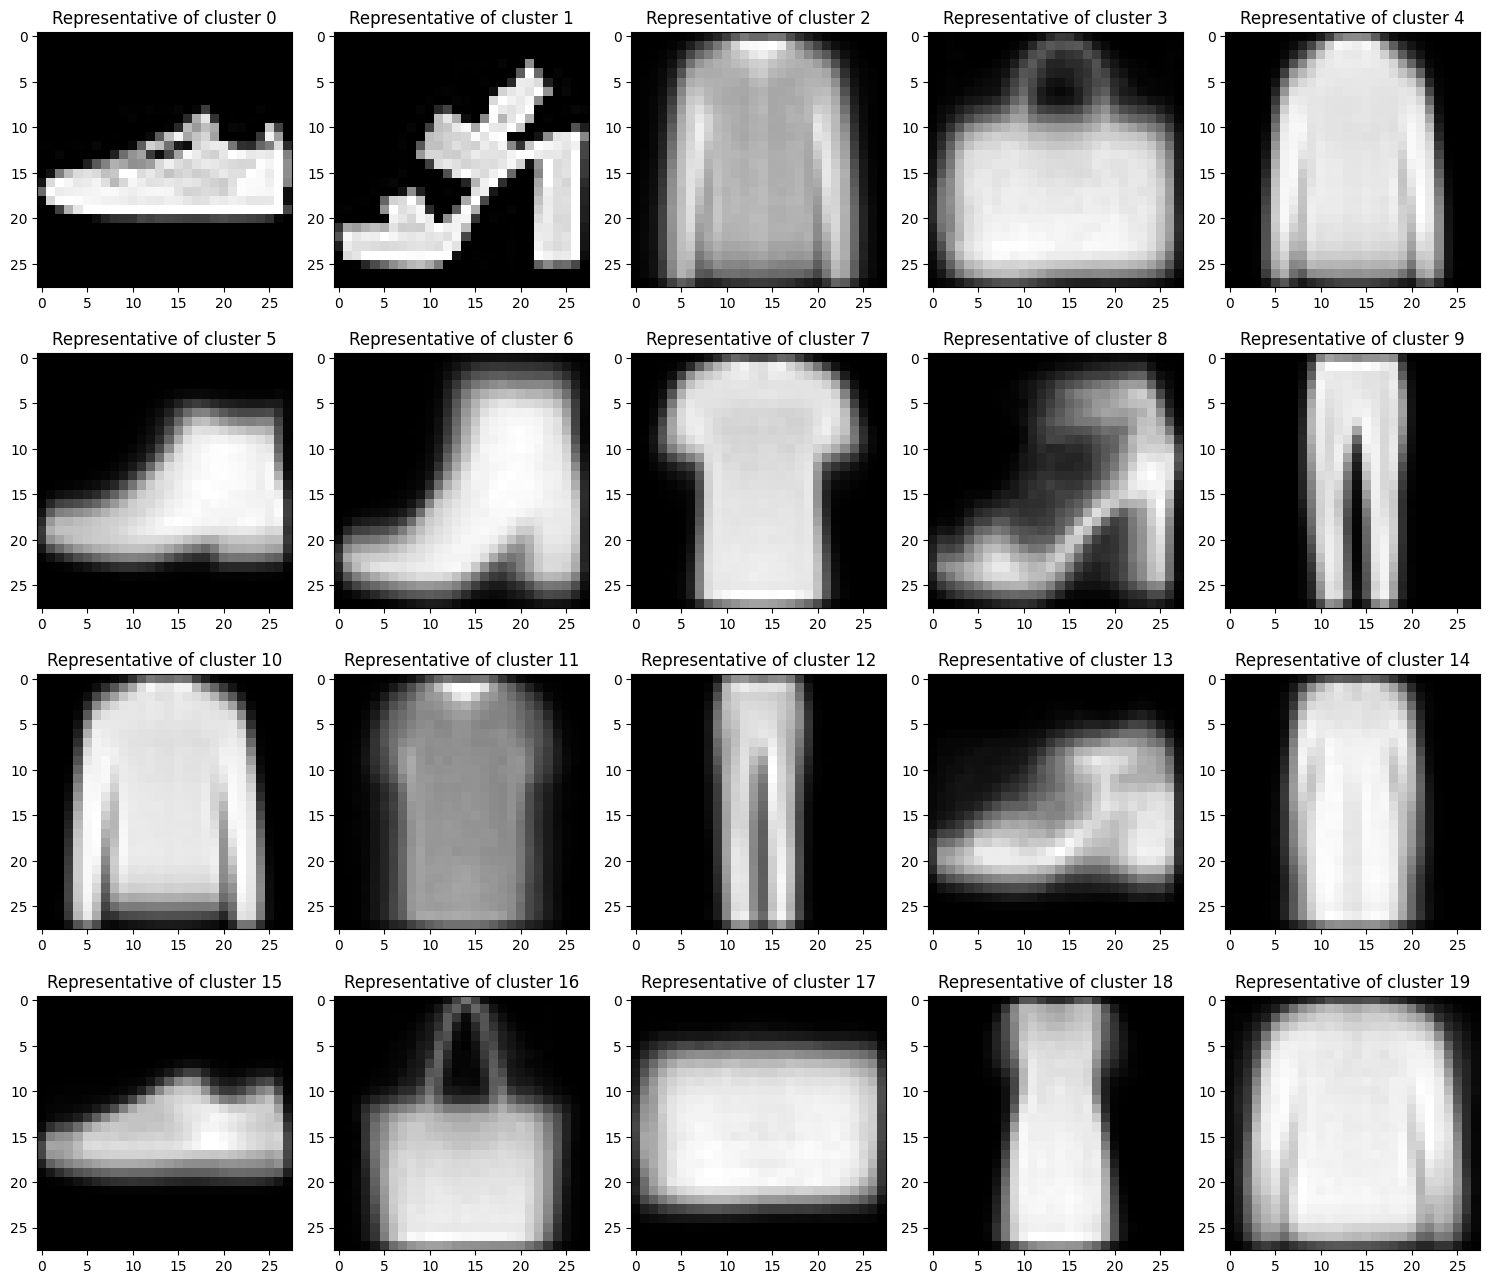

Best cluster: 0 with purity 1.000
Worst cluster: 19 with purity 0.296
- Cluster 0: purity=1.000, size=1
- Cluster 1: purity=1.000, size=1
- Cluster 2: purity=0.380, size=445
- Cluster 3: purity=0.973, size=146
- Cluster 4: purity=0.537, size=406
- Cluster 5: purity=0.710, size=365
- Cluster 6: purity=0.953, size=298
- Cluster 7: purity=0.768, size=380
- Cluster 8: purity=0.909, size=143
- Cluster 9: purity=1.000, size=349
- Cluster 10: purity=0.499, size=415
- Cluster 11: purity=0.313, size=531
- Cluster 12: purity=0.667, size=318
- Cluster 13: purity=0.604, size=265
- Cluster 14: purity=0.435, size=359
- Cluster 15: purity=0.615, size=774
- Cluster 16: purity=0.983, size=117
- Cluster 17: purity=0.968, size=221
- Cluster 18: purity=0.852, size=277
- Cluster 19: purity=0.296, size=189
ARI: 0.34329187510528



In [57]:
plot_class_representatives(class_reps_unbin)
print_evaluation_results(E_train[:N], assignments_unbin)

> Using the binarized images results in a lower ARI compared to using the original grayscale images. 

In [72]:
sankey_plot(E_train[:N], assignments_bin)
sankey_plot(E_train[:N], assignments_unbin)

In [73]:
import time
times = []
nnls = []
results = []
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
for k in ks:
    print(f"Running EM for K={k}")
    start = time.time()
    class_reps_tmp, priors_tmp, assignments_tmp, log_likelihoods_tmp = EM(F_train_bin[:N], k, init="random")
    end = time.time()
    times.append(end - start)
    nnls.append(-log_likelihoods_tmp[-1])
    results.append((class_reps_tmp, priors_tmp, assignments_tmp, log_likelihoods_tmp))
    print(f"K={k}, time={end - start:.2f}s, NNL={-log_likelihoods_tmp[-1]:.2f}")

Running EM for K=2
K=2, time=5.33s, NNL=1906814.56
Running EM for K=3
K=3, time=3.61s, NNL=1717285.09
Running EM for K=4
K=4, time=6.54s, NNL=1579988.13
Running EM for K=5
K=5, time=4.23s, NNL=1520406.75
Running EM for K=6
K=6, time=9.12s, NNL=1455273.83
Running EM for K=7
K=7, time=11.00s, NNL=1421896.19
Running EM for K=8
K=8, time=12.48s, NNL=1390644.36
Running EM for K=9
K=9, time=15.90s, NNL=1359283.46
Running EM for K=10
K=10, time=13.39s, NNL=1321548.43
Running EM for K=11
K=11, time=12.55s, NNL=1314936.58
Running EM for K=12
K=12, time=24.73s, NNL=1294256.62
Running EM for K=13
K=13, time=34.05s, NNL=1249018.52
Running EM for K=14
K=14, time=21.51s, NNL=1245267.08
Running EM for K=15
K=15, time=56.04s, NNL=1239072.95
Running EM for K=16
K=16, time=24.65s, NNL=1207866.35
Running EM for K=17
K=17, time=49.14s, NNL=1193736.61
Running EM for K=18
K=18, time=36.15s, NNL=1189181.52
Running EM for K=19
K=19, time=37.52s, NNL=1185035.22
Running EM for K=20
K=20, time=48.86s, NNL=117133

In [74]:
fig = px.line(x=ks, y=nnls)
fig.update_layout(title="Negative Log-Likelihood vs Number of Clusters",
                  xaxis_title="Number of clusters (K)",
                  yaxis_title="Negative Log-Likelihood", 
                  width=800, height=500)
fig.show()

fig = px.line(x=ks, y=times)
fig.update_layout(title="Computation Time vs Number of Clusters",
                  xaxis_title="Number of clusters (K)",
                  yaxis_title="Computation Time (s)",
                  width=800, height=500)
fig.show()

We can see that with rising k the log-likelihood improves, indicating that the model is better fitting the data as the number of clusters increases. Similarly to the digit dataset, we do not observe a clear elbow point in the log-likelihood curve, which would indicate an optimal number of clusters. This suggests that the fashion dataset may have a more complex structure that is not easily captured by a simple mixture model.